# Wine 데이터로 군집화하고 실루엣 분석하기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Clustering

In [2]:
from sklearn.datasets import load_wine
dataset = load_wine()
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [3]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

X_train, X_test, y_train, y_test = train_test_split(
    dataset.data,
    dataset.target,
    stratify=dataset.target,
    test_size=0.3,
    random_state=2021,
)

# Set up the random search with 5-fold cross validation
rs = RandomizedSearchCV(
    estimator=KMeans(),
    param_distributions={
        'init': ['k-means++', 'random'],
        'n_clusters': [len(set(dataset.target))],
        'n_init': randint(0,30), #10
    },
    cv=5,
    n_iter=100,
    return_train_score=True,
    random_state=2021,
    verbose=4, 
    n_jobs=-1,
)
rs.fit(X_train, y_train)
print('best_score_: {}'.format(rs.best_score_))
print('best_params_: {}'.format(rs.best_params_))

pred = rs.predict(X_test)
score = accuracy_score(y_test, pred)
print('accuracy_score: {}'.format(score))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
best_score_: -407825.2584574207
best_params_: {'init': 'random', 'n_clusters': 3, 'n_init': 1}
accuracy_score: 0.18518518518518517


In [4]:
def best_params(param='', margin=5):
    params = rs.best_params_
    minimum = 0 if params[param] - margin < 0 else params[param]
    maximum = params[param] + margin
    return np.arange(minimum, maximum, 1)

# Set up the grid search with 5-fold cross validation
gs = GridSearchCV(
    KMeans(),
    param_grid={
        'init': [rs.best_params_['init']],
        'n_clusters': [rs.best_params_['n_clusters']],
        'n_init': best_params('n_init'), #10
    },
    cv=5,
    verbose=4, 
    n_jobs=-1,
)
gs.fit(X_train, y_train)
print('best_score_: {}'.format(gs.best_score_))
print('best_params_: {}'.format(gs.best_params_))

pred = gs.predict(X_test)
score = accuracy_score(y_test, pred)
print('accuracy_score: {}'.format(score))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best_score_: -420565.1108745644
best_params_: {'init': 'random', 'n_clusters': 3, 'n_init': 3}
accuracy_score: 0.37037037037037035


In [5]:
from sklearn.cluster import KMeans
km = KMeans(
    init=gs.best_params_['init'], #'k-means++'
    n_init=gs.best_params_['n_init'], #10
    n_clusters=gs.best_params_['n_clusters'], #3
    random_state=2021,
    n_jobs=-1,
)
km.fit(X_train, y_train)

pred = km.predict(X_test)
score = accuracy_score(y_test, pred)
print('accuracy_score: {}'.format(score))

accuracy_score: 0.5370370370370371


## Clustering Visualize

In [6]:
# 차원 축소
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler().fit_transform(dataset.data)
pca = PCA(n_components=2).fit_transform(scaler)

In [7]:
df['pca_x'] = pca[:, 0]
df['pca_y'] = pca[:, 1]
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,pca_x,pca_y
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,3.316751,-1.443463
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,2.209465,0.333393
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,2.516740,-1.031151
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,3.757066,-2.756372
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1.008908,-0.869831


In [8]:
model = KMeans(
    init=gs.best_params_['init'], #'k-means++'
    n_init=gs.best_params_['n_init'], #10
    n_clusters=gs.best_params_['n_clusters'], #3
    random_state=2021,
    n_jobs=-1,
)
model.fit(pca)
pred = model.predict(pca)
df['cluster'] = model.labels_
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,pca_x,pca_y,cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,3.316751,-1.443463,2
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,2.209465,0.333393,2
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,2.516740,-1.031151,2
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,3.757066,-2.756372,2
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1.008908,-0.869831,2


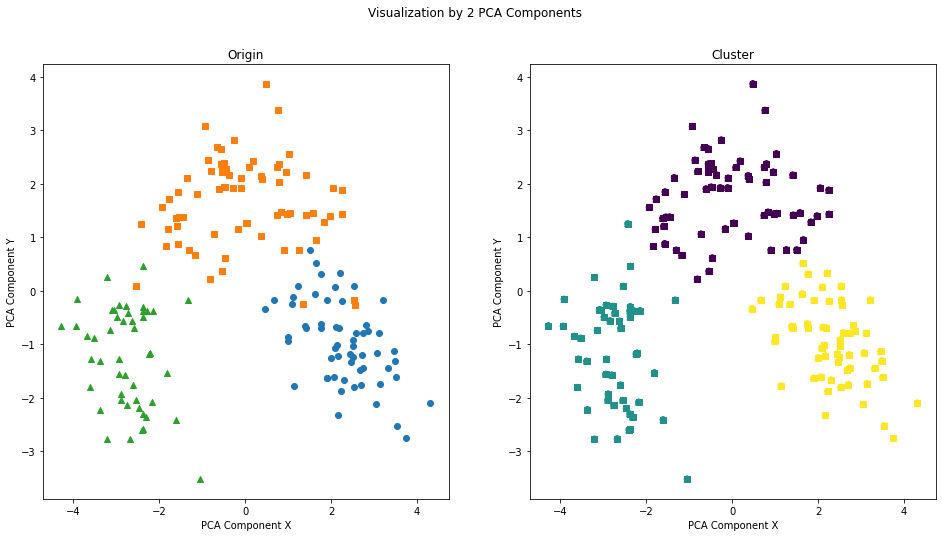

In [9]:
obj = {
    'xaxis': 'pca_x',
    'yaxis': 'pca_y',
    'xlabel': 'PCA Component X',
    'ylabel': 'PCA Component Y',
    'marker': ['o', 's', '^'],
}

# plot
plt.figure(figsize=(16,8))
plt.suptitle('Visualization by 2 PCA Components')

# origin
plt.subplot(1,2,1)
for i, marker in enumerate(obj.get('marker')):
    plt.scatter(
        x=df.query("target == @i")[obj.get('xaxis')], 
        y=df.query("target == @i")[obj.get('yaxis')], 
        marker=marker, 
    )
plt.title('Origin')
plt.xlabel(obj.get('xlabel'))
plt.ylabel(obj.get('ylabel'))

# cluster
plt.subplot(1,2,2)
for i, marker in enumerate(obj.get('marker')):
    plt.scatter(
        x=pca[:, 0],
        y=pca[:, 1],
        c=pred,
        marker=marker,
    )
plt.title('Cluster')
plt.xlabel(obj.get('xlabel'))
plt.ylabel(obj.get('ylabel'))

plt.show()

## Inertia
최적의 클러스터 개수 k를 알아내는 한가지 방법은 클러스터가 얼마나 밀집되어 있는지 나타내는 이너셔를 사용하는 것입니다. 이를 엘보우 방법이라고 합니다. 이렇게 하면 훈련 데이터의 차원을 크게 줄일 수 있습니다. 데이터셋의 차원을 줄이면 지도학습 알고리즘의 속도를 크게 높일 수 있습니다.

In [ ]:
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(fruits_2d)
    inertia.append(km.inertia_)
plt.plot(range(2,7), inertia)
plt.show()

## Silhouette

In [10]:
from sklearn.metrics import silhouette_score, silhouette_samples
score_samples = silhouette_samples(dataset.data, df.cluster)
df['silhouette_score'] = score_samples
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,pca_x,pca_y,cluster,silhouette_score
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,3.316751,-1.443463,2,0.571154
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,2.209465,0.333393,2,0.556547
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,2.516740,-1.031151,2,0.638287
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,3.757066,-2.756372,2,0.538121
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,1.008908,-0.869831,2,-0.631148


In [11]:
df.groupby('cluster')['silhouette_score'].mean()

cluster
0    0.024407
1    0.198750
2    0.359401
Name: silhouette_score, dtype: float64

In [12]:
start_cluster = 2
end_cluster = 10
scores = []

for n_clusters in np.arange(start_cluster, end_cluster):
    model = KMeans(n_clusters=n_clusters)
    model.fit(dataset.data)
    pred = model.predict(dataset.data)
    score = silhouette_score(dataset.data, pred)
    scores.append(score)

print('가장 높은 실루엣 점수를 가진 클러스터 수 : {0}'.format(np.argmax(scores) + start_cluster))
print('가장 높은 실루엣 점수를 가진 실루엣 점수 : {:.4f}'.format(scores[np.argmax(scores)]))

가장 높은 실루엣 점수를 가진 클러스터 수 : 2
가장 높은 실루엣 점수를 가진 실루엣 점수 : 0.6569


## Silhouette Visualize

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

def visualize_silhouette(cluster_lists, X_features):    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

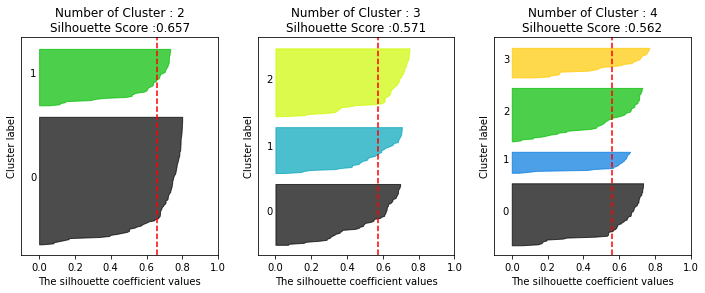

In [14]:
visualize_silhouette([2,3,4], dataset.data)